In [1]:
# import modules
%matplotlib inline
from matplotlib import pylab as plt
import track_analysis as ta
import pandas as pd
from IPython.parallel import Client
import time
import numpy as np

In [2]:
# import the tracks
tracks = ta.ImportTracks("/Users/uqdmatt2/Desktop/sxgfpDKDCtlcell15at100HzAtto647N_Tracks.xml")
trajs = tracks.trajectories

In [3]:
# trajs is a Pandas DataFrame so calling "head()" shows the first few rows
trajs.head()

,frame,particle,t,x,y,z
0,0,1,0.00,79.885198,64.846851,0
1,1,1,0.01,80.461321,64.735898,0
2,2,1,0.02,80.704122,64.596542,0
3,3,1,0.03,80.386165,65.084067,0
4,4,1,0.04,80.170241,64.733273,0


In [4]:
# since it is a Pandas DataFrame it is possible to calculate statistics for any column
trajs["particle"].max()

5209.0

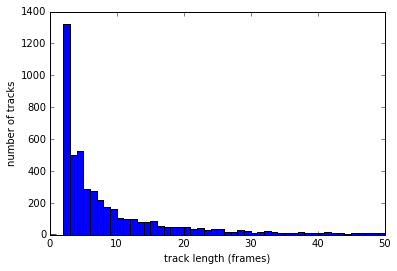

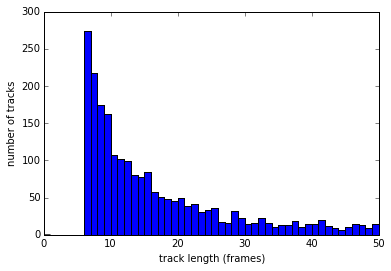

In [5]:
# use the "track_analysis" module to slice up the DataFrame
trajs_reduced = ta.filter_by_duration(trajs,5)

# find track lengths --> returns a Python list of track lengths (frames)
track_lengths = ta.track_lengths(trajs)

# track lengths of subset
track_lengths_subset = ta.track_lengths(trajs_reduced)

# find the index of the longest track
idx = track_lengths.index(max(track_lengths))
longest = trajs[trajs["particle"] == idx]

# plot a histogram of track lengths of the complete dataset
plt.hist(track_lengths,bins=50,range=[0,50])
plt.xlabel("track length (frames)")
plt.ylabel("number of tracks")
plt.show()

# plot a histogram of track lengths of the subset
plt.hist(track_lengths_subset,bins=50,range=[0,50])
plt.xlabel("track length (frames)")
plt.ylabel("number of tracks")
plt.show()

In [12]:
tl = ta.trajs_to_list(trajs_reduced)
pos = tl[0].set_index('frame')[['x', 'y']]
pos = pos.reindex(np.arange(pos.index[0], 1 + pos.index[-1]))

In [6]:
# let IPython take care of processing the data in parallel
# make sure to start the engines on the cluster (go to the "Home" tab)
# first make a Client to control the engines
c = Client()

# and create a balanced view to distribute the work evenly across the cpus
lview = c.load_balanced_view()
lview.block = True

In [7]:
# using IPython to parallel process means exposing a bit of code
# the "smss" method calculates the moments for mu = 0 : 7
# it fits to a log-log plot of moment vs. lagtime
# collects the slopes (gamma) and fits gamma vs mu
# when mu = 2 it calulates the diffusion coefficient

# here smss is an anonymous function
# t is the trajectory being processed
# mpp is pixel scale
# fps is frames per second
# maxlag is the maximum value for the time lag
smss = lambda t:ta.smss(t,mpp,fps,maxlag)

# create a view (essentially a subprocess)
dview = c[:]

# import the track_analysis module in the view
dview.execute('import track_analysis as ta')

# send the parameters above to the view
params=dict(mpp=0.1, fps=1/tracks.frame_interval, maxlag=max(trajs['t']))
dview.push(params)

<AsyncResult: _push>

In [8]:
# execute the results
#parallel
# time it
sp = time.time()

# we need to work on the trajectories as a list of DataFrames rather than
# one big collection
traj_list = ta.trajs_to_list(trajs_reduced)
print len(traj_list)
# map the anonymous function to the view
parallel_results = dview.map_sync(smss, traj_list)
print time.time() - sp

#serial - to prove that parallel processing is faster
# time it
#ss = time.time()

# just call the "imoments" function on the collection
# all looping is done internally but sequentially
#serial_results = ta.imoments(traj_reduced,0.1,1/tracks.frame_interval,max(trajs['t']))
#print time.time() - ss

2571
240.202476978


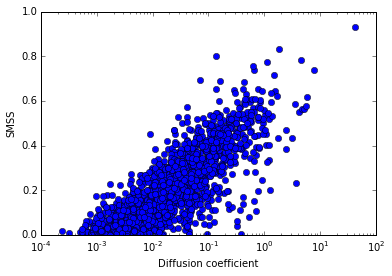

In [9]:
# retrieve the diffusion coefficients from the parallel results
idiff = ta.diffusion_coefficients(parallel_results)

# retrieve smss values for each track - i.e.
# the slope of gamma vs. mu for each track
# smss indicates the type of motion for self-similar tracks
# smss = 0 --> immobile
# smss = 0.5 --> brownian motion
# smss < 0.5 --> confined
# smss > 0.5 --> directed
ismss = ta.smss_values(parallel_results)

plt.semilogx(idiff,ismss,'o')
plt.ylim([0,1.0])
plt.xlabel("Diffusion coefficient")
plt.ylabel("SMSS")
plt.show()

In [96]:
num_results = len(parallel_results)
print num_results
smss_values = [parallel_results[i][0][0] for i in range(num_results)]

3624


In [133]:
filt = [(i,smss_values[i]) for i in range(len(smss_values)) if smss_values[i] > 0.7 and brown[i] < 0.8]

In [134]:
filt_pid = [filt[i][0] for i in range(len(filt))]

In [135]:
tl = [track_lengths[i] for i in filt_pid]

In [136]:
tl_idx = tl.index(max(tl))

In [137]:
tl_idx

23

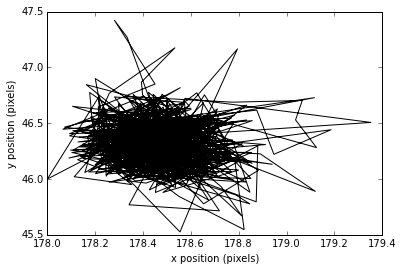

In [138]:
track = ta.single_track(trajs,tl_idx)
plt.plot(track["x"],track["y"],"k-")
plt.xlabel("x position (pixels)")
plt.ylabel("y position (pixels)")
plt.show()